### Simple script computing the Kolmogorov-Smirnov test for our Ice data
Compare whether the distribution of the observed data is same as the forecasted data. The KS-test is based on the comparison of cumulative frequency(?) curves of the probability densities. 
Instead of testing the similiarity of the observed data compared to an expected, theoretical distribution (as described in compendium), the similiarity to the forecasted data is tested. The test results regarding the null hypothesis (data originating from similiar distribution), will be used to evaluate the quality of the forecasted data in the region of marginal ice zones and whether forecasts in these zones might need modification ($FirstDraft$ -- $WorkOnFormulations$)

- Advantage with KS-test: No need to know what distribution the random variables (to be compared) belong to

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from scipy import stats

import joblib

In [2]:
# Load data
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])

#buoys_df

In [3]:
# Clean and define arrays for buoy of interest
# Buoy 10
kvs_10 = buoys_df.loc['KVS_SvalMIZ_10'].dropna()    # Drop NaN
kvs_10_index = kvs_10.index.values  # Set index (time-date)
kvs_10_t1m = np.array(kvs_10['temp_air'].values)    # Observed air temp at 1m
kvs_10_t2m = np.array(kvs_10['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_10_sic = np.array(kvs_10['sic'].values)         # sea-ice content
kvs_10_ist = np.array(kvs_10['temp_ice'].values)    # Observed ice temperature
# buoy 03
kvs_03 = buoys_df.loc['KVS_SvalMIZ_03'].dropna()    # Drop NaN
kvs_03_index = kvs_03.index.values  # Set index (time-date)
kvs_03_t1m = np.array(kvs_03['temp_air'].values)    # Observed air temp at 1m
kvs_03_t2m = np.array(kvs_03['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_03_sic = np.array(kvs_03['sic'].values)         # sea-ice content
kvs_03_ist = np.array(kvs_03['temp_ice'].values)    # Observed ice temperature
# buoy 07
kvs_07 = buoys_df.loc['KVS_SvalMIZ_07'].dropna()    # Drop NaN
kvs_07_index = kvs_07.index.values  # Set index (time-date)
kvs_07_t1m = np.array(kvs_07['temp_air'].values)    # Observed air temp at 1m
kvs_07_t2m = np.array(kvs_07['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_07_sic = np.array(kvs_07['sic'].values)         # sea-ice content
kvs_07_ist = np.array(kvs_07['temp_ice'].values)    # Observed ice temperature

C:\Users\matsip\AppData\Local\Temp\ipykernel_30568\24366704.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


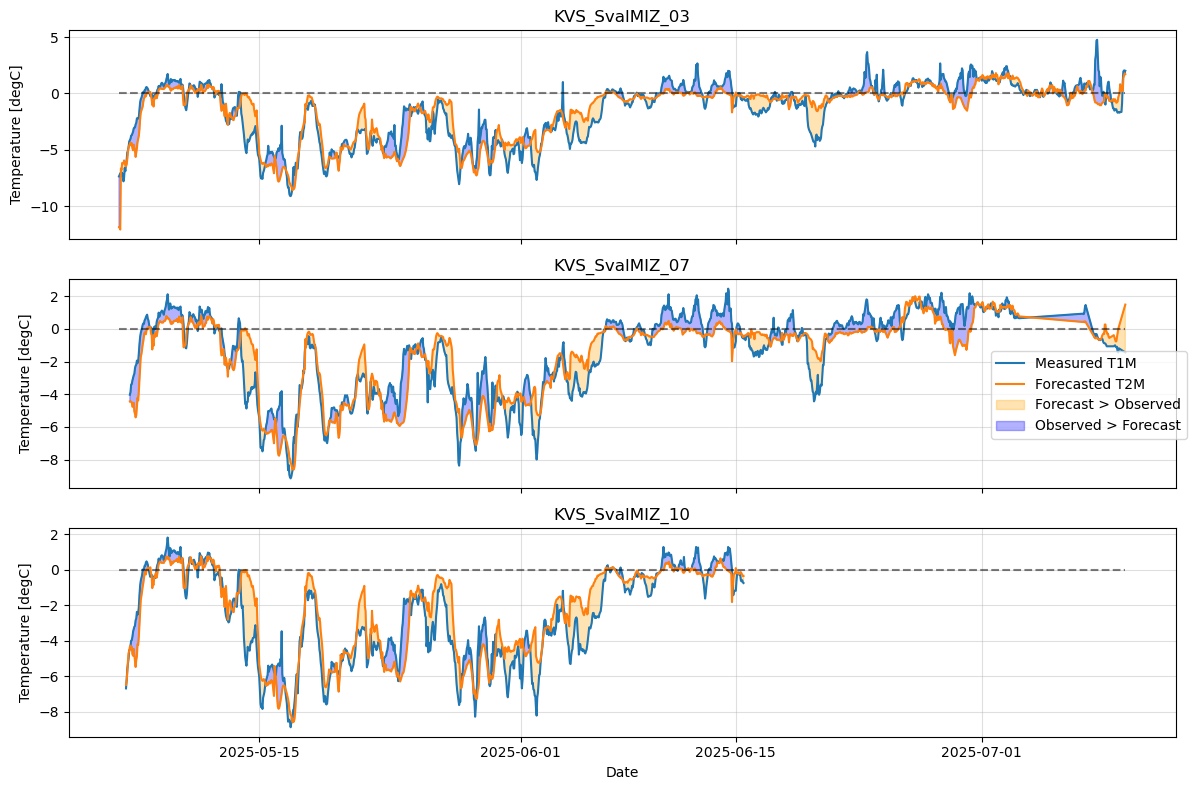

In [4]:
# Plot relevant data against time
t_all=np.concatenate([pd.to_datetime(kvs_03_index), pd.to_datetime(kvs_07_index), pd.to_datetime(kvs_10_index)])
t_min, t_max = t_all.min(), t_all.max()

fig, ax = plt.subplots(nrows = 3, figsize = (12, 8), sharex=True, constrained_layout=True)
# Buoy 03
ax[0].plot(pd.to_datetime(kvs_03_index), kvs_03_t1m)#, label='Measured T1M')
ax[0].plot(pd.to_datetime(kvs_03_index), kvs_03_t2m)#, label='Forecasted T2M')
above = kvs_03_t2m >= kvs_03_t1m
below = ~above
ax[0].fill_between(pd.to_datetime(kvs_03_index), kvs_03_t1m, kvs_03_t2m, where=above, color='orange', alpha=0.3, interpolate=True)
ax[0].fill_between(pd.to_datetime(kvs_03_index), kvs_03_t1m, kvs_03_t2m, where=below, color='blue', alpha=0.3, interpolate=True)
ax[0].set_title('KVS_SvalMIZ_03')

# Buoy 07
ax[1].plot(pd.to_datetime(kvs_07_index), kvs_07_t1m)#, label='Measured T1M')
ax[1].plot(pd.to_datetime(kvs_07_index), kvs_07_t2m)#, label='Forecasted T2M')
above = kvs_07_t2m >= kvs_07_t1m
below = ~above
ax[1].fill_between(pd.to_datetime(kvs_07_index), kvs_07_t1m, kvs_07_t2m, where=above, color='orange', alpha=0.3, interpolate=True)
ax[1].fill_between(pd.to_datetime(kvs_07_index), kvs_07_t1m, kvs_07_t2m, where=below, color='blue', alpha=0.3, interpolate=True)
ax[1].set_title('KVS_SvalMIZ_07')

# Buoy 10
ax[2].plot(pd.to_datetime(kvs_10_index), kvs_10_t1m, label = 'Measured T1M')   # Observed air temp at 1m
ax[2].plot(pd.to_datetime(kvs_10_index), kvs_10_t2m, label = 'Forecasted T2M') # Forecasted air temp at 2m
above = kvs_10_t2m >= kvs_10_t1m
below = ~above
ax[2].fill_between(pd.to_datetime(kvs_10_index), kvs_10_t1m, kvs_10_t2m, where=above, color='orange', alpha=0.3, interpolate=True, label='Forecast > Observed')
ax[2].fill_between(pd.to_datetime(kvs_10_index), kvs_10_t1m, kvs_10_t2m, where=below, color='blue', alpha=0.3, interpolate=True, label='Observed > Forecast')
ax[2].set_title('KVS_SvalMIZ_10')
ax[2].set_xlabel('Date')


for a in range(3):
    ax[a].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[a].grid(True, alpha=0.4)
    ax[a].set_ylabel('Temperature [degC]')
    ax[a].hlines(0, t_min, t_max, color='black', alpha=0.5, ls='--')


fig.legend(loc='right')
fig.tight_layout()

First visual inspection:
- Generally time series of buoys very similiar, training buoys with longer time series
- Training buoys (03, 07):
    - End of time series with higher temperatures around 0 degC
    - Seems like more underestimation of temperature of AROME in that period as well, compared to period of more negative data
    - Suitability for training ML-model?
        - More data available
        - More generalizable model
        - Less bias of test data

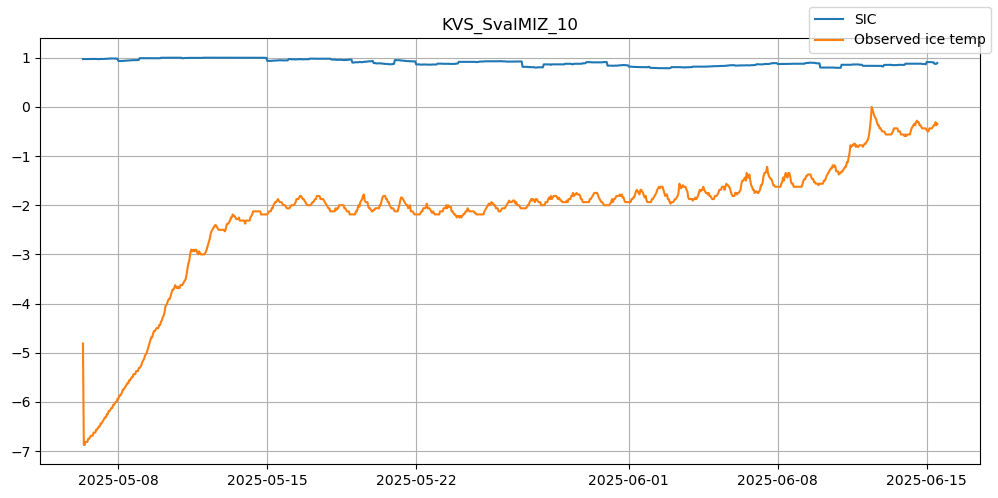

In [5]:
fig, ax = plt.subplots(nrows = 1, figsize = (10, 5))

ax.plot(pd.to_datetime(kvs_10_index), kvs_10_sic, label = 'SIC')    # Sea-ice content
ax.plot(pd.to_datetime(kvs_10_index), kvs_10_ist, label = 'Observed ice temp')  # Observed ice temp
ax.set_title('KVS_SvalMIZ_10')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid()
fig.legend()
fig.tight_layout()

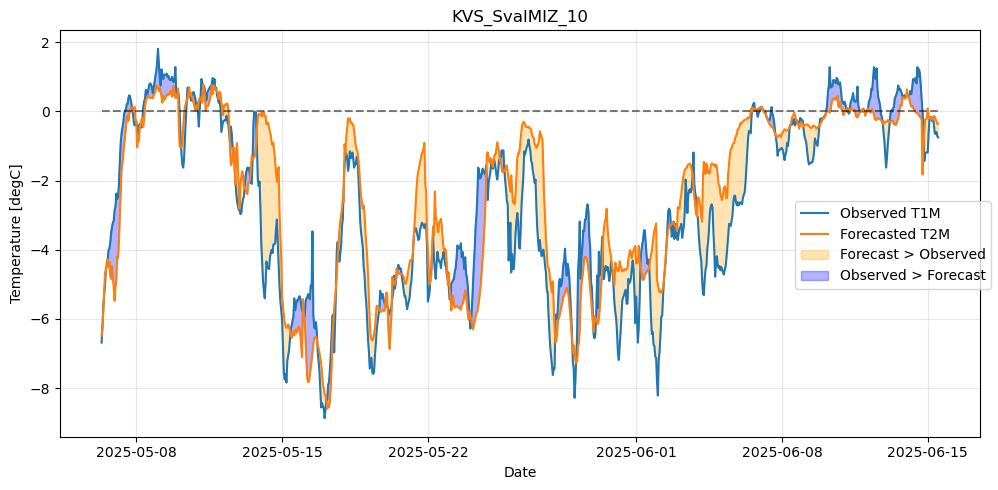

In [6]:
# Plot relevant data against time
fig, ax1 = plt.subplots(nrows = 1, figsize = (10, 5))
# Plot temperatures
ax1.plot(pd.to_datetime(kvs_10_index), kvs_10_t1m, label = 'Observed T1M')   # Observed air temp at 1m
ax1.plot(pd.to_datetime(kvs_10_index), kvs_10_t2m, label = 'Forecasted T2M') # Forecasted air temp at 2m
ax1.hlines(0, pd.to_datetime(kvs_10_index).min(), pd.to_datetime(kvs_10_index).max(), color='black', alpha=0.5, ls='--')
ax1.set_title('KVS_SvalMIZ_10')
ax1.set_ylabel('Temperature [degC]')
ax1.set_xlabel('Date')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.grid(alpha=.3)
# Masks
above = kvs_10_t2m >= kvs_10_t1m
below = ~above
ax1.fill_between(pd.to_datetime(kvs_10_index), kvs_10_t1m, kvs_10_t2m, where=above,
                 color='orange', alpha=0.3, interpolate=True, label='Forecast > Observed')
ax1.fill_between(pd.to_datetime(kvs_10_index), kvs_10_t1m, kvs_10_t2m, where=below,
                 color='blue', alpha=0.3, interpolate=True, label='Observed > Forecast')
# Plot sea ice content on sec. y-axis
#ax2 = ax1.twinx()
#ax2.plot(pd.to_datetime(kvs_10_index), kvs_10_sic*100, c='grey', alpha=0.5, label= 'Sea Ice content')
#ax2.set_ylabel('SIC [%]')
fig.legend(loc='right')
fig.tight_layout()
plt.show()

#### Visualize as histogram

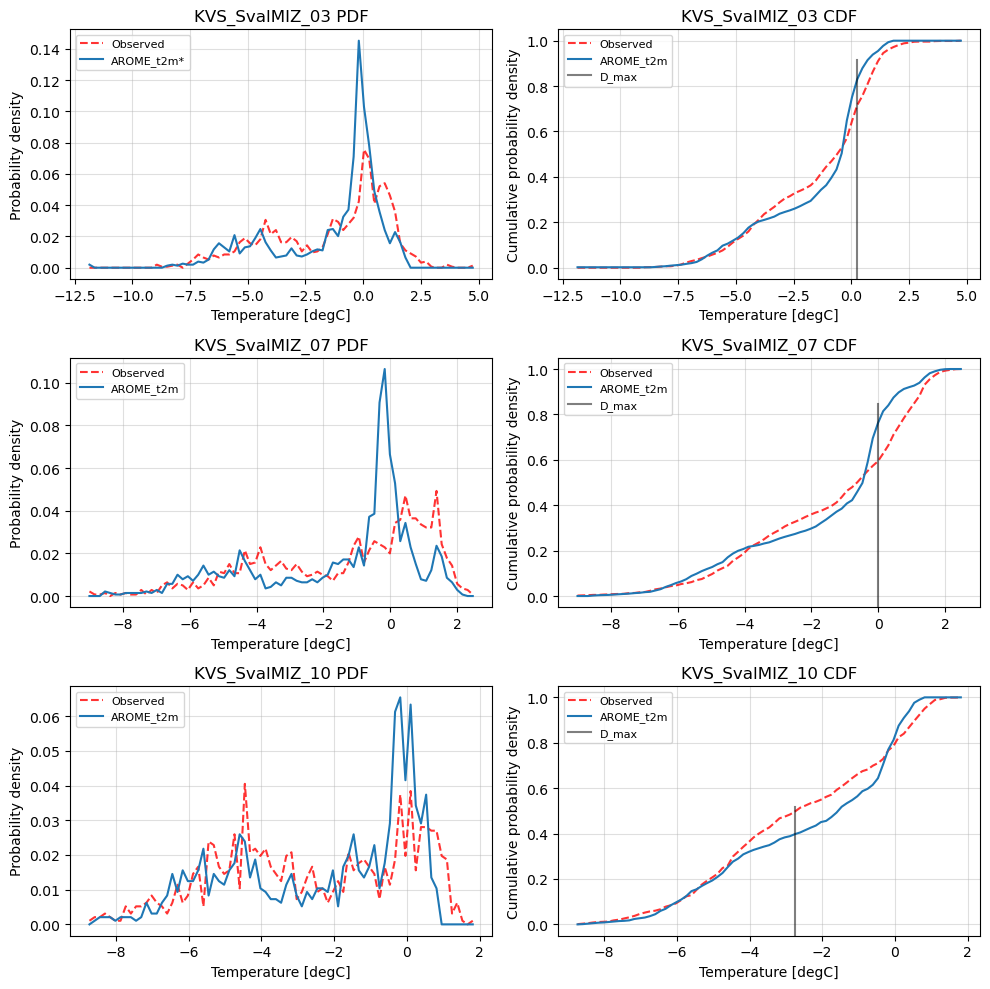

In [7]:
# Get pdf of air temperatures (observed, forecasted)
buoys = ['03', '07', '10']

all_data_kvs_03 = np.concatenate([np.asarray(kvs_03_t1m), np.asarray(kvs_03_t2m)]) # Prep data
all_data_kvs_07 = np.concatenate([np.asarray(kvs_07_t1m), np.asarray(kvs_07_t2m)]) # Prep data
all_data_kvs_10 = np.concatenate([np.asarray(kvs_10_t1m), np.asarray(kvs_10_t2m)]) # Prep data

all_data=np.concatenate([all_data_kvs_03, all_data_kvs_07, all_data_kvs_10])
bin_edges_kvs_03 = np.linspace(all_data_kvs_03.min(), all_data_kvs_03.max(), 76) #Get number of bins
bin_edges_kvs_07 = np.linspace(all_data_kvs_07.min(), all_data_kvs_07.max(), 76) #Get number of bins
bin_edges_kvs_10 = np.linspace(all_data_kvs_10.min(), all_data_kvs_10.max(), 76) #Get number of bins

# For pdf and cdf of observed air temp at 1m
# Buoy 03
counts_kvs_03_t1m, _ = np.histogram(kvs_03_t1m, bins = bin_edges_kvs_03, density = True)  # Get counts per bin
pdf_kvs_03_t1m = counts_kvs_03_t1m / sum(counts_kvs_03_t1m)  # Calculate bin probability for probability density fct.
cdf_kvs_03_t1m = np.cumsum(pdf_kvs_03_t1m)    # Calculate cumulative probability density fct.

# Buoy 07
counts_kvs_07_t1m, _ = np.histogram(kvs_07_t1m, bins = bin_edges_kvs_07, density = True)  # Get counts per bin
pdf_kvs_07_t1m = counts_kvs_07_t1m / sum(counts_kvs_07_t1m)  # Calculate bin probability for probability density fct.
cdf_kvs_07_t1m = np.cumsum(pdf_kvs_07_t1m)    # Calculate cumulative probability density fct.

# Buoy 10
counts_kvs_10_t1m, _ = np.histogram(kvs_10_t1m, bins = bin_edges_kvs_10, density = True)  # Get counts per bin
pdf_kvs_10_t1m = counts_kvs_10_t1m / sum(counts_kvs_10_t1m)  # Calculate bin probability for probability density fct.
cdf_kvs_10_t1m = np.cumsum(pdf_kvs_10_t1m)    # Calculate cumulative probability density fct.


# Initialize plot pdf & cdf
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize = (10, 10))

# Buoy 03
ax[0,0].plot(bin_edges_kvs_03[1:], pdf_kvs_03_t1m, label = 'Observed', c='red', ls='--', alpha=0.8)   # PDF
ax[0,1].plot(bin_edges_kvs_03[1:], np.cumsum(pdf_kvs_03_t1m), c='red', ls='--', alpha=0.8, label='Observed')       # Plot cdf observed temp.

# Buoy 07
ax[1,0].plot(bin_edges_kvs_07[1:], pdf_kvs_07_t1m, label = 'Observed', c='red', ls='--', alpha=0.8)   # PDF
ax[1,1].plot(bin_edges_kvs_07[1:], np.cumsum(pdf_kvs_07_t1m), c='red', ls='--', alpha=0.8, label='Observed')   # Plot cdf observed temp.

# Buoy 10
ax[2,0].plot(bin_edges_kvs_10[1:], pdf_kvs_10_t1m, label = 'Observed', c='red', ls='--', alpha=0.8)   # Plot pdf observed temp.
ax[2,1].plot(bin_edges_kvs_10[1:], np.cumsum(pdf_kvs_10_t1m), c='red', ls='--', alpha=0.8, label='Observed')   # Plot cdf observed temp.

# For pdf and cdf of forecasted air temp at 2m
# Buoy 03
counts_kvs_03_t2m, _ = np.histogram(kvs_03_t2m, bins = bin_edges_kvs_03, density = True)  # Get counts per bin
pdf_kvs_03_t2m = counts_kvs_03_t2m / sum(counts_kvs_03_t2m)  # Calculate bin probability for probability density fct.
cdf_kvs_03_t2m = np.cumsum(pdf_kvs_03_t2m)    # Calculate cumulative probability density fct.

# Buoy 07
counts_kvs_07_t2m, _ = np.histogram(kvs_07_t2m, bins = bin_edges_kvs_07, density = True)  # Get counts per bin
pdf_kvs_07_t2m = counts_kvs_07_t2m / sum(counts_kvs_07_t2m)  # Calculate bin probability for probability density fct.
cdf_kvs_07_t2m = np.cumsum(pdf_kvs_07_t2m)    # Calculate cumulative probability density fct.

# Buoy 10
counts_kvs_10_t2m, _ = np.histogram(kvs_10_t2m, bins = bin_edges_kvs_10, density = True)  # Get counts per bin
pdf_kvs_10_t2m = counts_kvs_10_t2m / sum(counts_kvs_10_t2m)  # Calculate bin probability for probability density fct.
cdf_kvs_10_t2m = np.cumsum(pdf_kvs_10_t2m)    # Calculate cumulative probability density fct.

# Buoy 03
ax[0,0].set_title('KVS_SvalMIZ_03 PDF')
ax[0,0].plot(bin_edges_kvs_03[1:], pdf_kvs_03_t2m, label = 'AROME_t2m*')   # PDF
ax[0,1].set_title('KVS_SvalMIZ_03 CDF')
ax[0,1].plot(bin_edges_kvs_03[1:], np.cumsum(pdf_kvs_03_t2m), label = 'AROME_t2m')   # Plot cdf observed temp.

# Buoy 07
ax[1,0].set_title('KVS_SvalMIZ_07 PDF')
ax[1,0].plot(bin_edges_kvs_07[1:], pdf_kvs_07_t2m, label = 'AROME_t2m')   # PDF
ax[1,1].set_title('KVS_SvalMIZ_07 CDF')
ax[1,1].plot(bin_edges_kvs_07[1:], np.cumsum(pdf_kvs_07_t2m), label = 'AROME_t2m')   # Plot cdf observed temp.

# Buoy 10
ax[2,0].set_title('KVS_SvalMIZ_10 PDF')
ax[2,0].plot(bin_edges_kvs_10[1:], pdf_kvs_10_t2m, label = 'AROME_t2m')   # Plot pdf observed temp.
ax[2,1].set_title('KVS_SvalMIZ_10 CDF')
ax[2,1].plot(bin_edges_kvs_10[1:], np.cumsum(pdf_kvs_10_t2m), label='AROME_t2m')   # Plot cdf observed temp.


D_nm_kvs_03 = np.max(np.abs(cdf_kvs_03_t2m - cdf_kvs_03_t1m))    # Get maximum distance of cdf's of observed and forecasted temp
loc_kvs_03 = np.argmax(np.abs(cdf_kvs_03_t2m - cdf_kvs_03_t1m))  # Get index of max distance between cdf's --> for KSI-test

D_nm_kvs_07 = np.max(np.abs(cdf_kvs_07_t2m - cdf_kvs_07_t1m))    # Get maximum distance of cdf's of observed and forecasted temp
loc_kvs_07 = np.argmax(np.abs(cdf_kvs_07_t2m - cdf_kvs_07_t1m))  # Get index of max distance between cdf's --> for KSI-test

D_nm_kvs_10 = np.max(np.abs(cdf_kvs_10_t2m - cdf_kvs_10_t1m))    # Get maximum distance of cdf's of observed and forecasted temp
loc_kvs_10 = np.argmax(np.abs(cdf_kvs_10_t2m - cdf_kvs_10_t1m))  # Get index of max distance between cdf's --> for KSI-test

ax[0,1].axvline(bin_edges_kvs_03[loc_kvs_03], ymin=0, ymax = cdf_kvs_03_t2m[loc_kvs_03], c = 'k', alpha=0.5, label='D_max') # Visualize max. distance of cdf's #cdf_kvs_03_t1m[loc_kvs_03]-0.05
ax[1,1].axvline(bin_edges_kvs_07[loc_kvs_07], ymin=0, ymax = cdf_kvs_07_t2m[loc_kvs_07], c = 'k', alpha=0.5, label='D_max') # Visualize max. distance of cdf's# cdf_kvs_07_t1m[loc_kvs_07]-0.1
ax[2,1].axvline(bin_edges_kvs_10[loc_kvs_10], ymin=0, ymax = cdf_kvs_10_t1m[loc_kvs_10], c = 'k', alpha=0.5, label='D_max') # Visualize max. distance of cdf's#cdf_kvs_10_t2m[loc_kvs_10]-0.05

[ax.grid(True, alpha=0.4) for ax in plt.gcf().get_axes()]
for a in ax.ravel():
    a.set_ylabel('Probability density')
for a in ax[:, 1].ravel():
    a.set_ylabel('Cumulative probability density')

[ax.set_xlabel('Temperature [degC]') for ax in plt.gcf().get_axes()]
for a in range(3):
    for b in range(2):
        ax[a,b].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

#### Kolmogorov-Smirnov (ice) test

Test: Kolmogorov-Smirnov 

Assumptions:

Null Hypothesis $H_0$: $F^0(x) = F^e(x)$, cumulative frequency of sample equals expected cumulative frequency from same distribution. 

Alternative Hypothesis $H_a$: $F^0(x) \ne F^e(x)$

Test statistic: D-test (maximum deviation D: $ D = max|F^e(x) - F^0(x)| $

Rejection criterion: $D = max|F^e(x) - F^0(x)| > \alpha$, if test-statistic D is bigger than the computed statistic $c(\alpha)$

#### KSI-test for all data combined??

In [8]:
# Significance level
alpha = .05 # Significance level
c_a = np.sqrt(-np.log(.5*alpha)*.5) # Critical value 

In [9]:
# Buoy 03, 07, 10
n_03, n_07, n_10, n_0307 = kvs_03.shape[0], kvs_07.shape[0], kvs_10.shape[0], kvs_03.shape[0]+kvs_07.shape[0]

scaler_1 = []
scaler_2 = []
for n in [n_03, n_07, n_10, n_0307]:
    scaler1= np.sqrt((n+n) / (n*n))
    scaler2= np.sqrt((n*n) / (n+n))
    scaler_1.append(scaler1), scaler_2.append(scaler2)


#scaler1_03, scaler1_07, scaler1_10 = np.sqrt((n+n) / (n*n))   # Standardizer for critical value
#scaler_2 = np.sqrt((n*n) / (n+n))   # Standardizer for test statistic

buoys=['KVS_03', 'KVS_07', 'KVS_10', 'KVS_0307']
D_nm = [D_nm_kvs_03, D_nm_kvs_07, D_nm_kvs_10]

for n in range(3):
    # Test 1
    test1 = D_nm[n] > c_a*scaler_1[n]
    print(f'Test 1 for {buoys[n]}')
    print(f"Two sample KS test. D_nm = {D_nm[n]:.3f}, Critical value: {c_a * scaler_1[n]:.3f}, rejected = {test1}")

    # Test 2
    test2 = scaler_2[n] * D_nm[n] >  c_a
    print(f'Test 2 for {buoys[n]}')
    print(f"Two sample KS test. D_nm = {scaler_2[n] * D_nm[n]:.3f}, Critical value: {c_a:.3f}, rejected = {test2}")

Test 1 for KVS_03
Two sample KS test. D_nm = 0.122, Critical value: 0.049, rejected = True
Test 2 for KVS_03
Two sample KS test. D_nm = 3.374, Critical value: 1.358, rejected = True
Test 1 for KVS_07
Two sample KS test. D_nm = 0.186, Critical value: 0.051, rejected = True
Test 2 for KVS_07
Two sample KS test. D_nm = 4.932, Critical value: 1.358, rejected = True
Test 1 for KVS_10
Two sample KS test. D_nm = 0.109, Critical value: 0.062, rejected = True
Test 2 for KVS_10
Two sample KS test. D_nm = 2.393, Critical value: 1.358, rejected = True


Based on the available sample size, the KSI-test rejects the null hypothesis that the cdf's of forecasted air temperature and the observed air temperature belong to the same distribution for all buoys. This test result implies the urgency for a correction of the air temperature forecast (?).

#### KS-Test post-processing

In [10]:
# Load obs. and forecast data
path_data = "../dataset/"
#kvs_10 = pd.read_csv(f"{path_data}buoy_10_w_models.csv", index_col=[0, 1])
buoy10_df_post = joblib.load("buoy10_df_post.joblib")
kvs_10 = buoy10_df_post.copy()


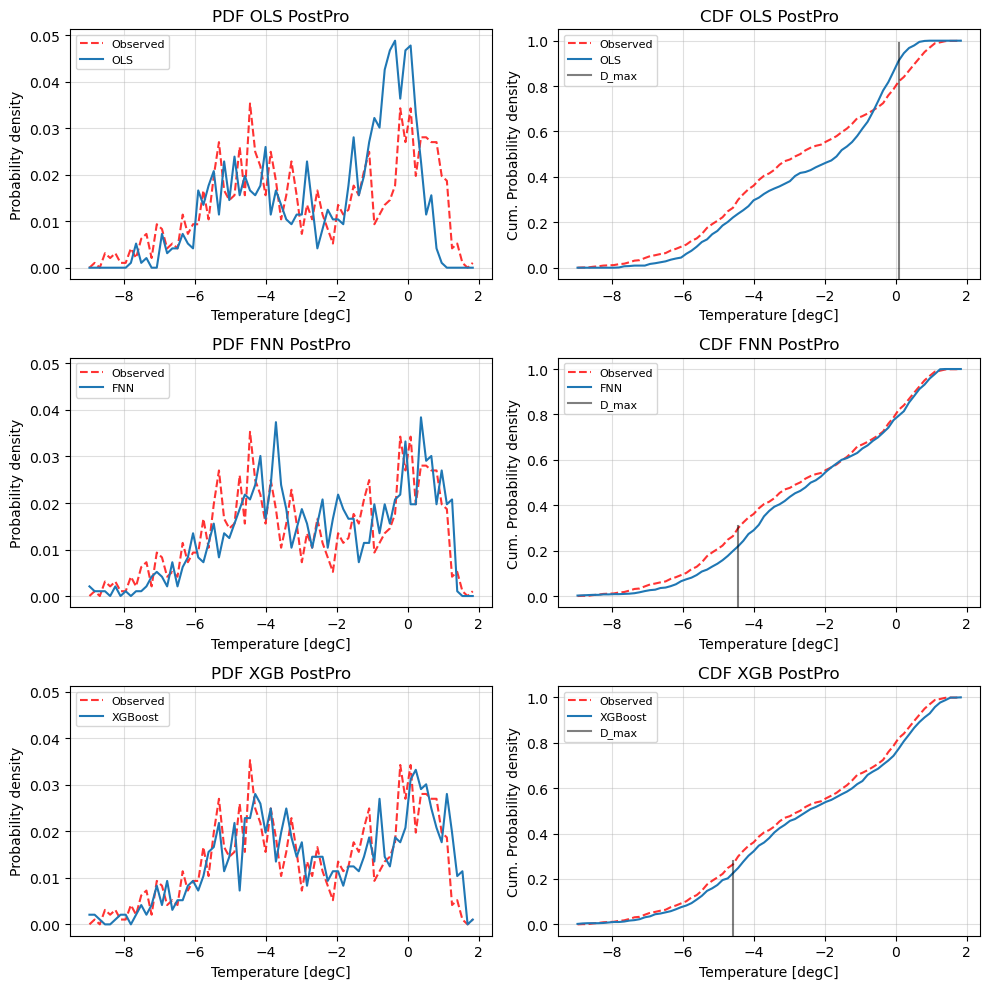

In [15]:
# Arrays for all temperatures of interest (observed, pre-, and post-processing)
kvs_10_t1m, kvs_10_t2m = np.array(kvs_10['temp_air'].values), np.array(kvs_10['arome_t2m'].values)
kvs_10_ols = np.array(kvs_10['ols_temp'].values)
kvs_10_nn, kvs_10_fnn = np.array(kvs_10['NN_temp'].values), np.array(kvs_10['FNN_temp'].values)
kvs_10_xgb, kvs_10_xgbdo, kvs_10_xgbpo = np.array(kvs_10['xgb_temp'].values), np.array(kvs_10['xgbdo_temp'].values), np.array(kvs_10['xgbpo_temp'].values)


kvs_10_all_temp=np.concatenate([kvs_10_t1m, kvs_10_t2m, kvs_10_ols, kvs_10_nn, kvs_10_fnn,kvs_10_xgb, kvs_10_xgbdo, kvs_10_xgbpo])
bin_edges=np.linspace(kvs_10_all_temp.min(), kvs_10_all_temp.max(), 76)

#kvs_10_all_titles=['kvs_10_t1m', 'AROME UnPro', 'OLS PostPro', 'NN PostPro', 'FNN PostPro', 'XGB PostPro', 'XGB_do PostPro', 'XGB_po PostPro']
#kvs_10_all_names=['Buoy_t1m', 'AROME_t2m', 'OLS', 'NN', 'FNN', 'XGBoost', 'XGBoost_do', 'XGBoost_po']
#kvs_10_all_list=[kvs_10_t1m, kvs_10_t2m, kvs_10_ols, kvs_10_nn, kvs_10_fnn, kvs_10_xgb, kvs_10_xgbdo, kvs_10_xgbpo]
kvs_10_all_titles=['kvs_10_t1m', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro'] # 'AROME UnPro',
kvs_10_all_names=['Buoy_t1m', 'OLS', 'FNN', 'XGBoost'] #'AROME_t2m', 
kvs_10_all_list=[kvs_10_t1m, kvs_10_ols, kvs_10_fnn, kvs_10_xgb] # kvs_10_t2m,

pdfs = []
cdfs = []

for temp in range(len(kvs_10_all_names)):
    counts, _ = np.histogram(kvs_10_all_list[temp], bins=bin_edges, density=True)
    pdf = counts / sum(counts)
    pdfs.append(pdf)
    cdfs.append(np.cumsum(pdf))


fig, ax = plt.subplots(nrows=len(kvs_10_all_names)-1, ncols=2, sharey='col', figsize=(10, 10))

D_nm_all = []
loc_D_all = []

for temp in range(1,len(kvs_10_all_names)):
    D_nm = np.max(np.abs(cdfs[temp] - np.abs(cdfs[0])))
    loc_D = np.argmax(np.abs(cdfs[temp] - np.abs(cdfs[0])))
    D_nm_all.append(D_nm)
    loc_D_all.append(loc_D)


    ax[temp-1, 0].plot(bin_edges[1:], pdfs[0], ls='--', c='red', alpha=0.8, label='Observed')  # Observed distribution
    ax[temp-1, 1].plot(bin_edges[1:], cdfs[0], ls='--', c='red', alpha=0.8, label='Observed')

    ax[temp-1,0].plot(bin_edges[1:], pdfs[temp], label=kvs_10_all_names[temp]) # Forecasted, post-processed 
    ax[temp-1,1].plot(bin_edges[1:], cdfs[temp], label=kvs_10_all_names[temp])
    if cdfs[temp][loc_D] < cdfs[0][loc_D]:
        ax[temp-1,1].axvline(bin_edges[loc_D], ymin=0, ymax=cdfs[0][loc_D],alpha=0.5, c='black', label='D_max') #cdfs[temp][loc_D]
    else:
        ax[temp-1,1].axvline(bin_edges[loc_D], ymin=0, ymax=cdfs[temp][loc_D],alpha=0.5, c='black', label='D_max') #cdfs[0][loc_D]

    ax[temp-1,0].set_title(f'PDF {kvs_10_all_titles[temp]}') 
    ax[temp-1,1].set_title(f'CDF {kvs_10_all_titles[temp]}') 

    ax[temp-1,0].set_xlabel(f'Temperature [degC]')
    ax[temp-1,1].set_xlabel(f'Temperature [degC]')

    ax[temp-1,0].set_ylabel(f'Probability density')
    ax[temp-1,1].set_ylabel(f'Cum. Probability density')

    ax[temp-1,0].grid(True, alpha=0.4)
    ax[temp-1,1].grid(True, alpha=0.4)

    ax[temp-1,0].legend(loc='upper left', fontsize=8)
    ax[temp-1,1].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()
#counts_t1m, _ = np.histogram(kvs_10_t1m, bins=bin_edges, density=True)

In [12]:
# Actual KS-test
scaler1 = []
scaler2 = []
kvs_10_all_list_it = kvs_10_all_list[1:]

for sample in kvs_10_all_list_it:
    n = sample.shape[0]
    scal1=np.sqrt((n+n) / (n*n))
    scal2=np.sqrt((n*n) / (n+n))
    scaler1.append(scal1), scaler2.append(scal2)


#print(f'Scaler length: {len(scaler1)}')
#print(f'D_nm length:{len(D_nm_all)}')
#print(f'KVS_10_all_list length: {len(kvs_10_all_list)}')
#print(f'KVS_10_all_names length: {len(kvs_10_all_names)}\n')


for n in range(0,len(kvs_10_all_list_it)):
    # test1
    test1 = D_nm_all[n] > c_a*scaler1[n]
    print(f'Test 1 for {kvs_10_all_names[n+1]}')
    print(f"Two sample KS test. D_nm = {D_nm_all[n]:.3f}, Critical value: {c_a * scaler1[n]:.3f}, rejected = {test1}")

    # test2
    test2 = scaler2[n] * D_nm_all[n] > c_a
    print(f'Test 2 for {kvs_10_all_names[n+1]}')
    print(f"Two sample KS test. D_nm = {scaler2[n] * D_nm_all[n]:.3f}, Critical value: {c_a:.3f}, rejected = {test2}\n")

Test 1 for AROME_t2m
Two sample KS test. D_nm = 0.109, Critical value: 0.062, rejected = True
Test 2 for AROME_t2m
Two sample KS test. D_nm = 2.393, Critical value: 1.358, rejected = True

Test 1 for OLS
Two sample KS test. D_nm = 0.105, Critical value: 0.062, rejected = True
Test 2 for OLS
Two sample KS test. D_nm = 2.301, Critical value: 1.358, rejected = True

Test 1 for FNN
Two sample KS test. D_nm = 0.081, Critical value: 0.062, rejected = True
Test 2 for FNN
Two sample KS test. D_nm = 1.777, Critical value: 1.358, rejected = True

Test 1 for XGBoost
Two sample KS test. D_nm = 0.051, Critical value: 0.062, rejected = False
Test 2 for XGBoost
Two sample KS test. D_nm = 1.117, Critical value: 1.358, rejected = False

